# Import & Setup

In [1]:
import sys
sys.path.append(r"C:/Users/mikha/Dropbox/mikhael_misc/Projects/My-Package")

import pandas as pd
import numpy as np
import h3

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from shapely.geometry import Polygon

import statsmodels.api as sm

import statsmodels.formula.api as smf

In [2]:
df = pd.read_csv(filepath_or_buffer=r"C:/Users/mikha/Dropbox/mikhael_misc/Projects/Policing Thesis/Modified Dataset - 2021 - One Row per Stop.csv",
                 index_col='Stop ID')

C:\Users\mikha\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3172: DtypeWarning: Columns (18,19,20,21,22,23,32,56) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df['Search Race'] = np.where(df['Search Conducted']==1, df['Race'], np.nan)
df['Arrest Race'] = np.where(df['Arrest']==1, df['Race'], np.nan)
df['Citation Race'] = np.where(df['Citation']==1, df['Race'], np.nan)

## Replace cols with Sparse-filled cols

In [4]:
sparse_cols = df.filter(like='Sparse').columns

# replace non sparse-filled cols with sparse-filled cols
for sparse_col in sparse_cols:
    df[sparse_col.replace(' - Sparse Filled', '')] = df[sparse_col]
    
# drop now-redundant cols
df.drop(columns=sparse_cols, inplace=True)

# Constants

## H3 Encoding

* Resolution options:
  * Official list w/ area https://h3geo.org/docs/core-library/restable/
  * Visualize at https://observablehq.com/@four43/h3-index-visualizer
* Looks like resolution=(7 or 8) is the way to go

In [5]:
RESOLUTIONS = [6,7,8,9,10]

race_set = sorted([race for race in df['Race'].unique().tolist() if race!='NATIVE AMERICAN'])

# Functions

## Create per cols

In [6]:
def create_PER_cols(dataframe:pd.DataFrame, numerator_cols:list, denominator_cols:list) -> None:
    for num_col in numerator_cols:
        for denom_col in denominator_cols:
            dataframe[f'{num_col} per {denom_col}'] = dataframe[num_col] / dataframe[denom_col]

## Race agg fncs

In [29]:
race_count_fncs = []

for race in race_set:
    # count_fnc_name = f'{race}'
    exec(f'def {race}(series): return (series=="{race}").sum()')
    race_count_fncs.append(eval(race))

# def count_ASIAN_stops(series):
#     return (series=='ASIAN').sum()

# def count_BLACK_stops(series):
#     return (series=='BLACK').sum()

# def count_HISPANIC_stops(series):
#     return (series=='HISPANIC').sum()

# def count_NATIVE_AMERICAN_stops(series):
#     return (series=='NATIVE AMERICAN').sum()

# def count_OTHER_stops(series):
#     return (series=='OTHER').sum()

# def count_WHITE_stops(series):
#     return (series=='WHITE').sum()

In [30]:
race_count_fncs

[<function __main__.ASIAN(series)>,
 <function __main__.BLACK(series)>,
 <function __main__.HISPANIC(series)>,
 <function __main__.OTHER(series)>,
 <function __main__.WHITE(series)>]

## Create grouped dataframes

### OG

In [101]:
def create_grouped_dataframes(dataframe:pd.DataFrame, resolutions:list, numerator_cols:list, denominator_cols:list) -> None:
    """
    Creates 'grouped_dataframes' dict 
    Note that numerator_cols and denominator_cols should all be bools (for aggregation to work properly)
    """
    
    num_agg_dict = {col:'sum' for col in numerator_cols}
    denom_agg_dict = {col:'sum' for col in denominator_cols}
    race_count_dict = {}# {'Race': race_count_fncs} #{'Race':[count_ASIAN_stops, count_BLACK_stops, count_HISPANIC_stops, count_NATIVE_AMERICAN_stops, count_OTHER_stops, count_WHITE_stops]}
    # remaining_cols = list(set(dataframe.columns) - set(num_agg_dict.keys()) - set(denom_agg_dict.keys()))
    # other_cols_agg = {'Stops':pd.NamedAgg(column="Latitude", aggfunc='count')}
    
    aggregation_dict = {**num_agg_dict, **denom_agg_dict, **race_count_dict}
    
    # only count stops that occurred in MC (based on recorded Longitude & Latitude)
    in_mc_mask = ((38.915292 <= dataframe['Latitude']) & (dataframe['Latitude'] <= 39.414658)
                  & (-77.554198 <= dataframe['Longitude']) & (dataframe['Longitude'] <= -76.864813))
    dataframe = dataframe[in_mc_mask]
    
    # global grouped_dataframes
    grouped_dataframes = dict()
    for resolution in resolutions:
        print(resolution)
                
        grouped_dataframes[resolution] = dataframe.groupby(by=f'H3 Encoding - Res={resolution}').agg(aggregation_dict)
        other_col_grouped = dataframe.groupby(by=f'H3 Encoding - Res={resolution}').agg(
            Stops=pd.NamedAgg(column='Latitude', aggfunc='count'))
        
        grouped_dataframes[resolution] = pd.concat([grouped_dataframes[resolution], other_col_grouped], axis='columns')
        
        # add geo-coordinates
        grouped_dataframes[resolution]['Longitude'] = grouped_dataframes[resolution].index.map(lambda x: h3.h3_to_geo(x)[0])
        grouped_dataframes[resolution]['Latitude'] = grouped_dataframes[resolution].index.map(lambda x: h3.h3_to_geo(x)[1])
        
        # return grouped_dataframes
        # Create "... Per Stop", "... Per Citation"
        create_PER_cols(dataframe=grouped_dataframes[resolution],
                        numerator_cols=numerator_cols + ['Stops'],
                        denominator_cols=denominator_cols)
        
        grouped_dataframes[resolution].replace([np.inf, -np.inf], np.nan, inplace=True)

        return grouped_dataframes


num_cols = ['Citation', 'Arrest', 'Search Conducted'] # these should be actions the police can decide on - e.g., stopping somebody
denom_cols = ['Fatal', 'Alcohol', 'Accident', 'Personal Injury', 'Property Damage'] # these should be "negative" traffic events that simply occur - e.g., accidents, fatalities
grouped_dataframes = create_grouped_dataframes(dataframe=df,
                          resolutions=RESOLUTIONS, 
                          numerator_cols=num_cols, denominator_cols=denom_cols)

### New

In [31]:
def create_grouped_dataframes2(dataframe:pd.DataFrame, resolutions:list, numerator_cols:list, denominator_cols:list) -> None:
    """
    Creates 'grouped_dataframes' dict 
    Note that numerator_cols and denominator_cols should all be bools (for aggregation to work properly)
    """
    
    num_agg_dict = {col:'sum' for col in numerator_cols}
    denom_agg_dict = {col:'sum' for col in denominator_cols}
    race_count_dict = {race_col: race_count_fncs for race_col in ['Race',
                                                                  'Search Race',
                                                                  'Citation Race',
                                                                  'Arrest Race']
                       }
    # other_cols_agg = {'Stops':pd.NamedAgg(column="Latitude", aggfunc='count')}
    
    aggregation_dict = {**num_agg_dict, **denom_agg_dict, **race_count_dict}
    
    # only count stops that occurred in MC (based on recorded Longitude & Latitude)
    in_mc_mask = ((38.915292 <= dataframe['Latitude']) & (dataframe['Latitude'] <= 39.414658)
                  & (-77.554198 <= dataframe['Longitude']) & (dataframe['Longitude'] <= -76.864813))
    dataframe = dataframe[in_mc_mask]
    
    # global grouped_dataframes
    grouped_dataframes = dict()
    for resolution in resolutions:
        print(resolution)
                
        grouped_dataframes[resolution] = dataframe.groupby(by=f'H3 Encoding - Res={resolution}').agg(aggregation_dict)
        
        # why am I doing it like this..? just put it in the agg dict ffs
        other_col_grouped = dataframe.groupby(by=f'H3 Encoding - Res={resolution}').agg(
            Stops=pd.NamedAgg(column='Latitude', aggfunc='count'))
        
        grouped_dataframes[resolution] = pd.concat([grouped_dataframes[resolution], other_col_grouped], axis='columns')
        
        # add geo-coordinates
        grouped_dataframes[resolution]['Longitude'] = grouped_dataframes[resolution].index.map(lambda x: h3.h3_to_geo(x)[0])
        grouped_dataframes[resolution]['Latitude'] = grouped_dataframes[resolution].index.map(lambda x: h3.h3_to_geo(x)[1])
        
        # # return grouped_dataframes
        # # Create "... Per Stop", "... Per Citation"
        # create_PER_cols(dataframe=grouped_dataframes[resolution],
        #                 numerator_cols=numerator_cols + ['Stops'],
        #                 denominator_cols=denominator_cols)
        
        grouped_dataframes[resolution].replace([np.inf, -np.inf], np.nan, inplace=True)
        
    return grouped_dataframes


num_cols = ['Citation', 'Arrest', 'Search Conducted'] # these should be actions the police can decide on - e.g., stopping somebody
denom_cols = ['Fatal', 'Alcohol', 'Accident', 'Personal Injury', 'Property Damage'] # these should be "negative" traffic events that simply occur - e.g., accidents, fatalities
grouped_dataframes2 = create_grouped_dataframes2(dataframe=df,
                          resolutions=RESOLUTIONS, 
                          numerator_cols=num_cols, denominator_cols=denom_cols)

6
7
8
9
10


In [39]:
def rename_agg_cols(columns:list) -> list:

    new_cols = []
    for col in columns:
        if type(col) == tuple and (col[1]=='sum'):
            new_cols.append(col[0])
        elif len(col)==2:
            if col[0] == 'Race':
                new_cols.append(f'Stops - {col[1]}')
            elif col[0] == 'Search Race':
                new_cols.append(f'Searches - {col[1]}')
            elif col[0] == 'Citation Race':
                new_cols.append(f'Citations - {col[1]}')
            elif col[0] == 'Arrest Race':
                new_cols.append(f'Arrests - {col[1]}')
        else:
            if type(col) != tuple:
                new_cols.append(col)
            else:
                raise ValueError(col, "what's this col?")
    
    return new_cols

# new_cols
# list(zip(grouped_dataframes2[6].columns, new_cols))

[(('Citation', 'sum'), 'Citation'),
 (('Arrest', 'sum'), 'Arrest'),
 (('Search Conducted', 'sum'), 'Search Conducted'),
 (('Fatal', 'sum'), 'Fatal'),
 (('Alcohol', 'sum'), 'Alcohol'),
 (('Accident', 'sum'), 'Accident'),
 (('Personal Injury', 'sum'), 'Personal Injury'),
 (('Property Damage', 'sum'), 'Property Damage'),
 (('Race', 'ASIAN'), 'Stops - ASIAN'),
 (('Race', 'BLACK'), 'Stops - BLACK'),
 (('Race', 'HISPANIC'), 'Stops - HISPANIC'),
 (('Race', 'OTHER'), 'Stops - OTHER'),
 (('Race', 'WHITE'), 'Stops - WHITE'),
 (('Search Race', 'ASIAN'), 'Searches - ASIAN'),
 (('Search Race', 'BLACK'), 'Searches - BLACK'),
 (('Search Race', 'HISPANIC'), 'Searches - HISPANIC'),
 (('Search Race', 'OTHER'), 'Searches - OTHER'),
 (('Search Race', 'WHITE'), 'Searches - WHITE'),
 (('Citation Race', 'ASIAN'), 'Citations - ASIAN'),
 (('Citation Race', 'BLACK'), 'Citations - BLACK'),
 (('Citation Race', 'HISPANIC'), 'Citations - HISPANIC'),
 (('Citation Race', 'OTHER'), 'Citations - OTHER'),
 (('Citation R

In [17]:
create_PER_cols(dataframe=grouped_dataframes2[6],
                        numerator_cols=num_cols + ['Stops'],
                        denominator_cols=denom_cols)

KeyError: 'Citation'

# Analysis

## Total #Cells

In [16]:
for res in RESOLUTIONS:
    num_cells = len(grouped_dataframes[res])
    square_size = np.sqrt(len(grouped_dataframes[res])).round(0)
    print(f'Resolution {res} has {num_cells} many cells (approx {square_size} X {square_size})')

Resolution 6 has 35 many cells (approx 6.0 X 6.0)
Resolution 7 has 141 many cells (approx 12.0 X 12.0)
Resolution 8 has 588 many cells (approx 24.0 X 24.0)
Resolution 9 has 2706 many cells (approx 52.0 X 52.0)
Resolution 10 has 11153 many cells (approx 106.0 X 106.0)


## Stops per Accident

### Scatterplots


COLOR-CODE BY MOST COMMON RACE IN EACH AREA (some kind of pd.agg fnc)

In [18]:
np.log(df['Latitude'].head())

Stop ID
0    3.663299
1    3.668016
2    3.668218
3    3.667669
4    3.663158
Name: Latitude, dtype: float64

In [20]:
for res in RESOLUTIONS:
    px.scatter(data_frame=grouped_dataframes[res],
               x='Accident',
               y='Stops',
               size='Accident',
               color=np.log(grouped_dataframes[res]['Stops per Accident']),
               trendline='ols',
               title=res).show()

# Regressions

In [45]:
WLS_R2_dict = {}

for resol in RESOLUTIONS:

    mod = smf.wls(formula='Accident ~ Stops', 
                  data=grouped_dataframes[resol],
                  weights=grouped_dataframes[resol]['Stops'])
    
    WLS_R2_dict[resol] = mod.rsquared
    
    res = mod.fit(cov_type='HC3')
    print(f'!!!!!!!!!!!!!!       {resol}       !!!!!!!!!!!!!!')
    print(res.summary())

!!!!!!!!!!!!!!       6       !!!!!!!!!!!!!!
                            WLS Regression Results                            
Dep. Variable:               Accident   R-squared:                       0.946
Model:                            WLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     98.36
Date:                Sat, 30 Oct 2021   Prob (F-statistic):           1.99e-11
Time:                        15:48:50   Log-Likelihood:                -328.05
No. Observations:                  35   AIC:                             660.1
Df Residuals:                      33   BIC:                             663.2
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercep

# Plotting

### Map

In [ ]:
def scatter_map(res:int):
    """Needs 'Latitude', 'Longitude' columns"""
    
    center_lat = df['Latitude'].median()
    center_long = df['Longitude'].median()

    fig = px.scatter_geo(grouped_dataframes[res], lon='Longitude', lat='Latitude', color='Stops per Accident')
    fig.update_layout(
            title = f'Stops per Accident - Resolution={res}',
            geo_scope='usa')
    fig.update_geos(
        center=dict(lon=center_long, lat=center_lat), 
        projection_scale=40
        )
    fig.show()

In [ ]:
for res in RESOLUTIONS:
    scatter_map(res=res)

In [ ]:
scatter_map(6)

In [ ]:
center_lat = df['Latitude'].median()
center_long = df['Longitude'].median()

fig = px.scatter_geo(grouped_dataframes[9], lon='Longitude', lat='Latitude', color='Stops per Accident')
fig.update_layout(
        title = f'Stops per Accident - {res}',
        geo_scope='usa')
fig.update_geos(
    center=dict(lon=center_long, lat=center_lat), 
    projection_scale=50
    )
fig.show()

### Unweighted

### Weighted

In [ ]:
grouped_dataframes[9]['Stops ']
fig = px.scatter(grouped_dataframes[9], x='Stops', y='Accident', size='Stops', trendline='ols')
fig.show()

<AxesSubplot:>

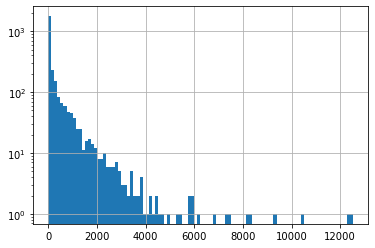

In [26]:
grouped_dataframes[9]['Stops'][grouped_dataframes[9]['Stops'] > 50]

# Density Plots

In [121]:
len(df) / df['Accident'].sum()

48.04715099021946

In [116]:
fig = px.histogram(data_frame=grouped_dataframes[6],
                   histfunc="count",
                   x='Stops per Accident',
                #    color='Stops',
                #    hover_data='Stops',
                #    log_x=True,
                   nbins=600)
fig.show()

In [15]:
fig = px.histogram(data_frame=grouped_dataframes2[9][grouped_dataframes2[9]['Stops'] > 150],
                   histfunc="count",
                   x='Stops per Accident',
                   log_x=True,
                  #  color='Stops',
                   nbins=600)
fig.show()

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of [('Citation', 'sum'), ('Arrest', 'sum'), ('Search Conducted', 'sum'), ('Fatal', 'sum'), ('Alcohol', 'sum'), ('Accident', 'sum'), ('Personal Injury', 'sum'), ('Property Damage', 'sum'), ('Race', 'count_ASIAN_stops'), ('Race', 'count_BLACK_stops'), ('Race', 'count_HISPANIC_stops'), ('Race', 'count_OTHER_stops'), ('Race', 'count_WHITE_stops'), ('Search Race', 'count_ASIAN_stops'), ('Search Race', 'count_BLACK_stops'), ('Search Race', 'count_HISPANIC_stops'), ('Search Race', 'count_OTHER_stops'), ('Search Race', 'count_WHITE_stops'), ('Citation Race', 'count_ASIAN_stops'), ('Citation Race', 'count_BLACK_stops'), ('Citation Race', 'count_HISPANIC_stops'), ('Citation Race', 'count_OTHER_stops'), ('Citation Race', 'count_WHITE_stops'), ('Arrest Race', 'count_ASIAN_stops'), ('Arrest Race', 'count_BLACK_stops'), ('Arrest Race', 'count_HISPANIC_stops'), ('Arrest Race', 'count_OTHER_stops'), ('Arrest Race', 'count_WHITE_stops'), 'Stops', 'Longitude', 'Latitude'] but received: Stops per Accident

In [ ]:
fig = px.histogram(data_frame=grouped_dataframes[9][grouped_dataframes[9]['Stops'] > 50],
                   histfunc="count",
                   x='Stops per Accident',
                   nbins=600)
fig.show()

In [21]:
fig = make_subplots(cols=1, rows=len(grouped_dataframes),
                    shared_xaxes=True,
                    shared_yaxes=True,
                    vertical_spacing=.1)
hist_plot_dict = {}

for i,resolution in enumerate(RESOLUTIONS):
    # hist_plot_dict[resolution] = go.Histogram(x=grouped_dataframes[resolution]['Stops per Accident'])

    fig.append_trace(go.Histogram(histfunc="avg",
                                  x=grouped_dataframes[resolution]['Stops per Accident'],
                                  nbinsx=200,
                                  name=resolution),
                     col=1, row=i+1)

fig.update_xaxes(range=[0, 2000])
fig.update_yaxes(range=[0, 1000])
fig.update_layout(title_text="Customizing Subplot Axes", height=700, width=700)
fig.show()


In [ ]:
fig = go.Figure()
for resolution in RESOLUTIONS:
    fig.add_trace(go.Histogram(x=grouped_dataframes[resolution]['Stops per Accident']))
    
fig.show()

# QA

## Is #Stops correct?

In [ ]:
grouped_dataframes[9].loc['89f04280923ffff', 'Stops']==len(df[df['H3 Encoding - Res=9']=='89f04280923ffff'])

## Is #Arrests correct?

In [ ]:
grouped_dataframes[9].loc['89f042803abffff', 'Arrest'] == df[df['H3 Encoding - Res=9']=='89f04280923ffff']['Arrest'].sum()

## Are divisions being done correctly?

In [ ]:
sample_num_stops = len(df[df['H3 Encoding - Res=9']=='89f04280927ffff'])
sample_num_accidents = df[df['H3 Encoding - Res=9']=='89f04280927ffff']['Accident'].sum()

grouped_dataframes[9].loc['89f04280927ffff', 'Stops per Accident'] == sample_num_stops / sample_num_accidents

# CHECK EQUALITY ACROSS AGGREGATIONS

In [ ]:
for var in ['Stops', 'Citation', 'Accident']:
    for res in RESOLUTIONS:
        print(res, var, grouped_dataframes[res][var].sum())